In [144]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import trange

### Load data

In [13]:
train, val, test, data = (np.load("../data/task2_%s.npz" % f)
                    for f in ("train", "val", "test", "data"))
xtr, ytr, xval, yval, xte, yte, xdata, ydata = (
  torch.from_numpy(arr).float()
  for arr in (train["x"], train["y"], val["x"], val["y"], test["x"], test["y"], data["x"], data["y"])
)

In [20]:
# extract number of labels (= number of appliances) from dataset
assert ydata.min() == 0, "minimum label should be 0"
num_appliances = (ydata.max() + 1).int().item()
num_appliances

10

### Classification model

In [30]:
# fix the household to get something working at first before using FL
household_idx = 0

In [94]:
class RNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.head = nn.Linear(num_layers * hidden_size, num_classes)

    def forward(self, x):
        B, _L, F = x.shape # batch size, sequence length, number of features
        assert F == self.input_size, (
            "got a batch with %d features, expected %d" % (F, self.input_size)
        )

        # Create initial hidden state
        h_0 = torch.zeros(self.num_layers, B, self.hidden_size)

        # Propagate input through RNN
        _, h_out = self.rnn(x, h_0)

        # When the hidden state comes out of the RNN, it has shape 
        # (num_layers, batch_size, hidden_size), however we want to feed it into
        # the linear layer. For that, we want to concatenate the hidden states
        # of all layers and use that as the input to the linear layer. We can do
        # that by first moving the batch dimension to the front, and then
        # combine the last two dimensions.
        h_out = h_out.permute(1, 0, 2) # move batch dimension to front
        h_out = h_out.reshape(B, -1) # combine last two dimensions
        assert h_out.shape == (B, self.num_layers * self.hidden_size)
        out = self.head(h_out)

        return out

In [191]:
model = RNN(
  num_classes=num_appliances,
  input_size=1, # the total consumption at each step is our input
  # tunable hyperparameters below
  hidden_size=50,
  num_layers=5,
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses = [], []

In [192]:
num_epochs, val_frequency = 500, 10
# see where last training ended
last = 0 if not train_losses else train_losses[-1][0]
for epoch in (pbar := trange(last, last + num_epochs)):
  # sample a batch
  batch_size = 100
  batch_ix = torch.randint(0, len(xtr), (batch_size,))
  xb = xtr[household_idx][batch_ix]
  yb = ytr[household_idx][batch_ix]

  # forward pass
  y_pred = model(xb[..., None])
  loss = F.cross_entropy(y_pred, yb.long())

  # backward pass
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  train_losses.append([epoch, loss.item()])
  
  if epoch % val_frequency == 0:
    # compute loss on validation set
    val_losses.append([
      epoch,
      F.cross_entropy(model(xval[household_idx, ..., None]),
                      yval[household_idx].long()).item(),
    ])
  
  # attach losses to progress bar
  vl = f"{val_losses[-1][1]:.02f}" if val_losses else "?"
  pbar.set_description(f"tl={loss.item():.02f}, vl={vl}")

tl=0.62, vl=3.29: 100%|██████████| 500/500 [00:58<00:00,  8.59it/s]


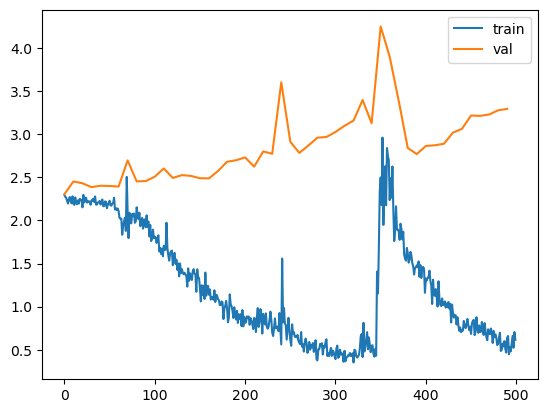

In [193]:
plt.plot(*zip(*train_losses), label="train")
plt.plot(*zip(*val_losses), label="val")
plt.legend();